## Wprowadzenie

* **Przetwarzanie języka naturalnego (NLP):** Dziedzina informatyki, sztucznej inteligencji i językoznawstwa, która zajmuje się tworzeniem modeli obliczeniowych przetwarzających i rozumiejących język naturalny. Obejmuje to: sprawienie, aby komputer rozumiał semantyczną grupowanie słów (np. kot i pies są semantycznie bardziej podobne niż kot i łyżka), przekształcanie tekstu na mowę, tłumaczenie językowe i wiele innych.

* **Analiza sentymentu:** Jest to interpretacja i klasyfikacja emocji (pozytywnych, negatywnych i neutralnych) w danych tekstowych przy użyciu technik analizy tekstu. Analiza sentymentu pozwala organizacjom identyfikować publiczne nastawienie do określonych słów lub tematów.

W tym notatniku opracujemy **model analizy sentymentu** w celu zaklasyfikowania tweeta jako **Pozytywny lub Negatywny**.


In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import os 
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
print(os.getcwd())
nltk.download('wordnet')
nltk.download('omw-1.4')

F:\Projekty\doktorat\Zajęcia\uslugi sieciowe i ml\twitter\src


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tomasz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tomasz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## <a name="p2">Importowanie zbioru danych</a>
Zbiór danych, który jest używany, to **sentiment140 dataset**. Zawiera on 1 600 000 tweetów wyekstrahowanych za pomocą **API Twittera**. Tweety zostały oznaczone **(0 = Negatywne, 4 = Pozytywne)** i mogą być używane do wykrywania sentymentu.

*[Dane treningowe nie są doskonale skategoryzowane, ponieważ zostały utworzone przez otagowanie tekstu zgodnie z obecnością emoji. Dlatego każdy model zbudowany na podstawie tego zbioru danych może mieć niższą niż oczekiwano dokładność, ponieważ zbiór danych nie jest doskonale skategoryzowany.]*

**Zawiera następujące 6 pól:**
1. **sentiment**: polarność tweeta *(0 = negatywny, 4 = pozytywny)*
2. **ids**: Identyfikator tweeta *(2087)*
3. **date**: data tweeta *(sobota 16 maja 23:58:44 UTC 2009)*
4. **flag**: Zapytanie (lyx). Jeśli nie ma zapytania, wartość ta to NO_QUERY.
5. **user**: użytkownik, który napisał tweeta *(robotickilldozr)*
6. **text**: tekst tweeta *(Lyx is cool)*

Wymagamy tylko pól **sentiment** i **text**, więc odrzucamy pozostałe.

Ponadto zmieniamy pole **sentiment**, aby miało nowe wartości odzwierciedlające sentyment. **(0 = Negatywny, 1 = Pozytywny)**


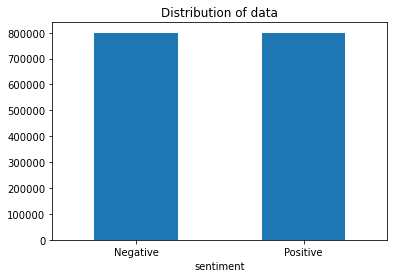

In [3]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../data/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Przetwarzanie wstępne tekstu</a>
**Przetwarzanie wstępne tekstu** to tradycyjnie ważny krok w zadaniach **Przetwarzania Języka Naturalnego (NLP)**. Przekształca tekst na bardziej przyswajalną formę, dzięki czemu algorytmy uczenia maszynowego mogą działać lepiej.

**Podjęte kroki przetwarzania wstępnego to:**
1. **Zamiana na małe litery:** Każdy tekst jest przekształcany na małe litery.
2. **Zastępowanie URLi:** Linki zaczynające się od **"http", "https" lub "www"** są zastępowane przez **"URL"**.
3. **Zastępowanie emoji:** Emoji są zastępowane przy użyciu predefiniowanego słownika zawierającego emoji wraz z ich znaczeniem. *(np.: ":)" na "EMOJIsmile")*
4. **Zastępowanie nazw użytkowników:** Nazwy użytkowników zaczynające się od @ są zastępowane słowem **"USER"**. *(np.: "@Kaggle" na "USER")*
5. **Usuwanie nie-alfabetycznych znaków:** Znaki inne niż cyfry i litery alfabetyczne są zastępowane spacją.
6. **Usuwanie powtarzających się liter:** 3 lub więcej powtarzających się liter jest zastępowanych przez 2 litery. *(np.: "Heyyyy" na "Heyy")*
7. **Usuwanie krótkich słów:** Słowa krótsze niż 2 litery są usuwane.
8. **Usuwanie stopwords:** Stopwords to angielskie słowa, które nie dodają wiele znaczenia do zdania. Mogą być bezpiecznie ignorowane bez uszczerbku dla znaczenia zdania. *(np.: "the", "he", "have")*
9. **Lematyzacja:** Lematyzacja to proces przekształcania słowa do jego podstawowej formy. *(np.: "Great" na "Good")*


In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [5]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [6]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 114 seconds


## <a name="p4">Analiza danych</a>
Teraz przeanalizujemy przetworzone dane, aby lepiej je zrozumieć. Stworzymy **Chmury Słów** dla tweetów **Pozytywnych i Negatywnych** z naszego zbioru danych, aby zobaczyć, które słowa pojawiają się najczęściej.


### Word-Cloud dla negatywnych tweetów.

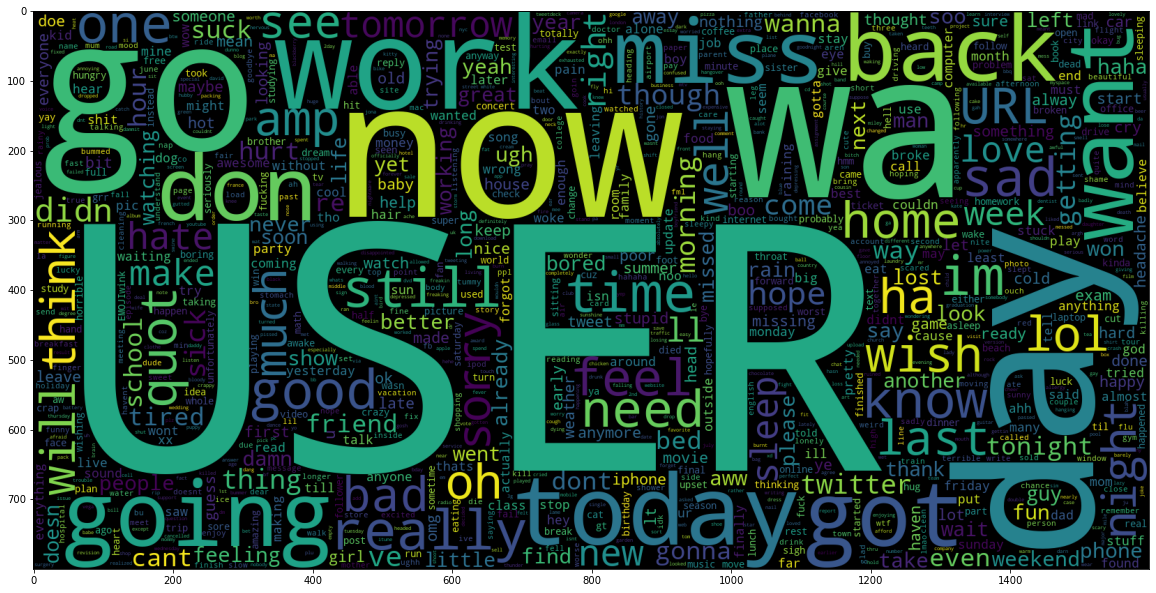

In [7]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud dla pozytywnych tweetów.

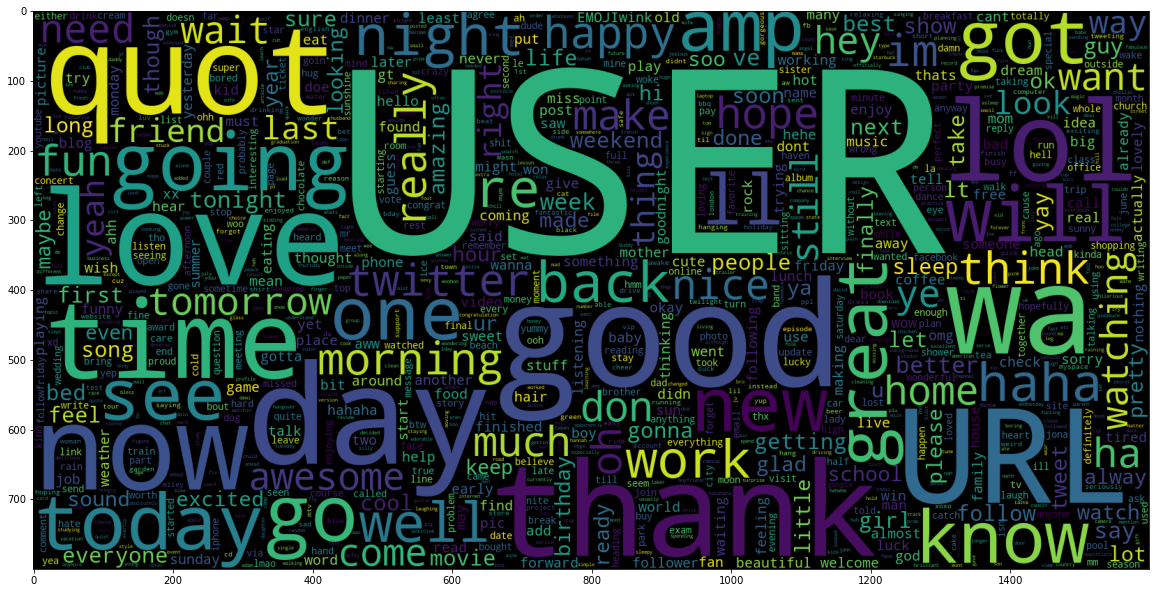

In [8]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a name="p5">Podział danych</a>
Przetworzone dane są podzielone na 2 zestawy danych:
* **Dane treningowe:** Zbiór danych, na którym będzie trenowany model. Zawiera 95% danych.
* **Dane testowe:** Zbiór danych, na którym model będzie testowany. Zawiera 5% danych.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')
X_train
print(len(X_train))
X_test

Data Split done.
1520000


['want to compete want hard competition want to rally want to feel the power coming out of the engine want to compete ',
 'it seems we are stuck on the ground in amarillo they have put ground stop for all flight leaving for denver said update in an hour ',
 'where the are my pinking shear rarararrarararr babyproofing while cutting stuff make me stick shear random place amp forget them ',
 '0ff t0 the meetin hate when ppl v0lunteer my free time grr ',
 'reply me pls ',
 'USER jazz in india is just honda strategy to prove they can make affordable car for the working class it still doesn fit me ',
 'aah met boy he seems nice im happy now ',
 'USER URL sport center you guy are too legit to quit wooww ',
 'USER not bad bit grumpy cause of exam but generally ok ta ',
 'USER can watch it what is it ',
 'good nite everbody had long day and did project now it is finally time to get some rest peace ',
 'morning twitter world gonna start my day with the coldest lucozade can find ',
 'USER hahaa t

## <a name="p6">Wektoryzator TF-IDF</a>
**TF-IDF wskazuje, jakie znaczenie ma słowo w celu zrozumienia dokumentu lub zbioru danych.** Wyjaśnijmy to na przykładzie. Załóżmy, że masz zbiór danych, w którym uczniowie piszą wypracowanie na temat Mojej Domu. W tym zbiorze danych słowo a pojawia się wiele razy; jest to słowo o wysokiej częstotliwości w porównaniu z innymi słowami w zbiorze danych. Zbiór danych zawiera inne słowa, takie jak dom, mieszkanie, pokoje itp., które pojawiają się rzadziej, więc ich częstotliwość jest niższa i niosą więcej informacji w porównaniu do słowa. To jest intuicja stojąca za TF-IDF.

**Wektoryzator TF-IDF** konwertuje zbiór surowych dokumentów na **macierz cech TF-IDF**. **Wektoryzator** zazwyczaj jest trenowany tylko na zbiorze **X_train**.

**ngram_range** to zakres liczby słów w sekwencji. *[np. "bardzo drogi" to 2-gram, który jest traktowany jako dodatkowa cecha osobno od "bardzo" i "drogi", gdy masz zakres n-gramów (1,2)]*

**max_features** określa liczbę cech do rozważenia. *[Uporządkowane według częstotliwości cech w korpusie]*.


In [10]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


### <a name="p7">Transformacja zbioru danych</a>
Transformacja zbiorów danych **X_train** i **X_test** na macierz **cech TF-IDF** przy użyciu **Wektoryzatora TF-IDF**. Te zbiory danych będą używane do trenowania modelu i testowania go.


In [11]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')
X_test

Data Transformed.


## <a name="p8">Tworzenie i ocena modeli</a>

Tworzymy 3 różne typy modeli dla naszego problemu analizy sentymentu:
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Klasyfikacja wektorów wspierających liniowo (LinearSVC)**
* **Regresja logistyczna (LR)**

Ponieważ nasz zbiór danych nie jest **niezrównoważony**, tzn. ma równą liczbę **Pozytywnych i Negatywnych** prognoz. Wybieramy **dokładność** jako naszą metrykę oceny. Ponadto, tworzymy **macierz pomyłek** aby zrozumieć, jak nasz model radzi sobie z oboma typami klasyfikacji.


### funkcja do testowania modelu

In [12]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



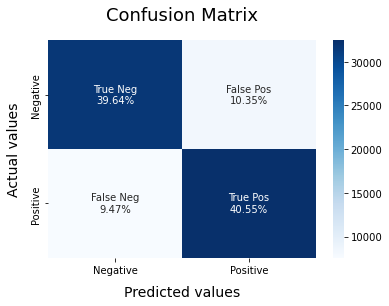

In [13]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



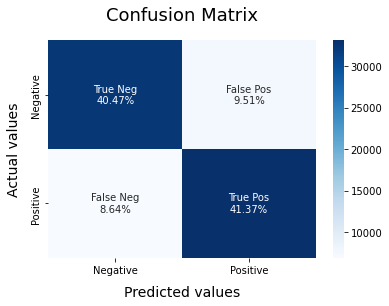

In [14]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



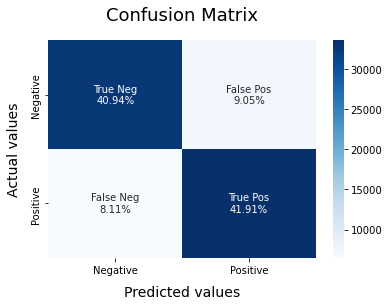

In [15]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

We can clearly see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves nearly **82% accuracy** while classifying the sentiment of a tweet.

Although it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on. It also achieves **80% accuracy** while calssifying.

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser and BernoulliNB, Logistic Regression Model** for later use.

In [16]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

## <a name="p10">Używanie modelu.</a>

Aby użyć modelu do **przewidywania sentymentu**, musimy zaimportować **Wektoryzator** i **model LR** za pomocą **Pickle**.

Wektoryzator może być używany do przekształcania danych na macierz cech TF-IDF.
Natomiast model może być używany do przewidywania sentymentu przekształconych danych.
Tekst, którego sentyment ma być przewidziany, musi jednak zostać wcześniej przetworzony.

In [17]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('../models/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('../models/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I  twitter love",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                  I  twitter love  Positive
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
